# 2.2 - Macrobond web API - Screening on a Concept

*Performing coverage checks based on Macrobond's RegionKey attribute*

This notebook aims to provide examples of how to use Macrobond's web API call methods as well as insights on the key attributes used to display the output in an understandable format.

We will focus here on using the Search method based on a **RegionKey** input. This helps you find the market standard in each region for a pre-defined concept.

*Full error handling is omitted for brevity*

***

## Importing packages

In [3]:
from matplotlib import pyplot 

from macrobond_financial.common import Credentials
from macrobond_financial.web import WebClient

***

## Authentication

If you have a Macrobond's web API account, enter your *client_id* and *client_secret* below.

In [4]:
credentials = Credentials()

***

## Get the data
Our typical workflow starts with the information we find from a time series' metadata. From there, we will seek further information on these attributes. But, it is absolutely possible to skip this step and go to section **Searching time series carrying a similar concept** directly.
Let's now request a time series to have a look at its metadata.
Feel free to refer to https://api.macrobondfinancial.com/swagger/index.html to get the comprehensive list of web API endpoints and parameters used.

In the example below, we will use time series `aulama0227`: 
> **Australia, Unemployment, Total, Rate, SA**

***

## Visualising the metadata
Let's visualise the metadata in a Pandas dataframe. 
You will see below the full list of metadata attributes available for our time series. 
Feel free to visit this page for more information on these fields: https://help.macrobond.com/technical-information/common-metadata/

In [5]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    data_frame = api.series.get_one_entitie('aulama0227').metadata_as_data_frame()
data_frame

,Attributes
Name,aulama0227
DayMask,127
Frequency,monthly
AbsCode,A84423050A
Category,lama
Class,stock
Description,Rate
Region,[au]
RegionKey,[labor_unemp]
Release,rel_auaboslama


We can spot in the metadata response `RegionKey = labor_umemp`. Let's use it as a parameter in the Search method.

***

## Searching time series carrying a similar concept

In [6]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    data_frame = api.search.search(
        entity_types='TimeSeries',
        must_have_values={
            'RegionKey': 'labor_unemp'
        },
        include_discontinued=False,
    ).data_frame(columns=['Name', 'FullDescription', 'Region', 'RegionKey', 'Frequency', 'Source', 'FirstRevisionTimeStamp'])
data_frame.head(10)

,Name,FullDescription,Region,RegionKey,Frequency,Source,FirstRevisionTimeStamp
0,czlama0051,"Czech Republic, Unemployment, Total, Rate",[cz],[labor_unemp],monthly,src_czmlsa,2020-02-10T08:21:00Z
1,hulama0288,"Hungary, Unemployment, Males & Females, Rate (...",[hu],[labor_unemp],monthly,src_huhcso,2019-03-28T08:00:00Z
2,idlama0006,"Indonesia, Unemployment, Rate",[id],[labor_unemp],semiannual,src_idsi,2020-02-13T05:09:00Z
3,lvlama0001,"Latvia, Unemployment, Registered, Rate",[lv],[labor_unemp],monthly,src_lvsea,2020-02-11T06:51:00Z
4,silama0254,"Slovenia, Unemployment, Men & Women, Rate",[si],[labor_unemp],monthly,src_sies,2019-11-21T11:10:00Z
5,itlama0497,"Italy, Unemployment, Rate, Women & Men, Aged 1...",[it],[labor_unemp],monthly,src_itistat,2016-08-31T08:00:00Z
6,sglama0117,"Singapore, Unemployment, Overall, Percent, SA",[sg],[labor_unemp],quarterly,src_sgmom,2020-01-30T02:00:00Z
7,phlama0003,"Philippines, Unemployment, Rate",[ph],[labor_unemp],quarterly,src_phnso01,2019-12-16T07:51:00Z
8,filama0862,"Finland, Unemployment, Rate, By Gender, Males ...",[fi],[labor_unemp],monthly,src_fistatfin,2018-05-23T06:07:00Z
9,islama0236,"Iceland, Unemployment, Rate, By Gender, Males ...",[is],[labor_unemp],monthly,src_isstatice,2019-03-28T09:03:00Z


### We will now focus on the Point-in-Time (PiT) series in this coverage check
Let's isolate the first element of the Region attribute. While most of the time series carry one region only, some can have multiple regions with for instance "gb" and "gb,city_[xxx]".
Let's also convert the date-time to years only.

In [7]:
data_frame['RegionString'] = data_frame['Region'].apply(lambda x: ', '.join(map(str, x)))
data_frame['FirstRevisionYear'] = data_frame['FirstRevisionTimeStamp'].str[:4]
data_frame.head(3)

,Name,FullDescription,Region,RegionKey,Frequency,Source,FirstRevisionTimeStamp,RegionString,FirstRevisionYear
0,czlama0051,"Czech Republic, Unemployment, Total, Rate",[cz],[labor_unemp],monthly,src_czmlsa,2020-02-10T08:21:00Z,cz,2020
1,hulama0288,"Hungary, Unemployment, Males & Females, Rate (...",[hu],[labor_unemp],monthly,src_huhcso,2019-03-28T08:00:00Z,hu,2019
2,idlama0006,"Indonesia, Unemployment, Rate",[id],[labor_unemp],semiannual,src_idsi,2020-02-13T05:09:00Z,id,2020


### Displaying the new DataFrame
Let's see how our transformations have been applied by isolating on a few columns: `df.iloc[rows,[columns]]`. Note that we are also dropping NaN values in the FirstRevisionDate column: `df.dropna(subset=['FirstRevisionDate'])`

In [8]:
data_frame_final = data_frame.dropna(subset=['FirstRevisionYear']).iloc[0:1000, [0,1,8,4,5,7]]
data_frame_final

,Name,FullDescription,FirstRevisionYear,Frequency,Source,RegionString
0,czlama0051,"Czech Republic, Unemployment, Total, Rate",2020,monthly,src_czmlsa,cz
1,hulama0288,"Hungary, Unemployment, Males & Females, Rate (...",2019,monthly,src_huhcso,hu
2,idlama0006,"Indonesia, Unemployment, Rate",2020,semiannual,src_idsi,id
3,lvlama0001,"Latvia, Unemployment, Registered, Rate",2020,monthly,src_lvsea,lv
4,silama0254,"Slovenia, Unemployment, Men & Women, Rate",2019,monthly,src_sies,si
...,...,...,...,...,...,...
106,brlama0024,"Brazil, Continuous National Household Sample S...",2018,monthly,src_bribge,br
108,uylama8101,"Uruguay, Unemployment, Total, Country, Rate",2019,monthly,src_uyine,uy
109,svlama0001,"El Salvador, Unemployment, Total, Total",2020,annual,src_svdstat,sv
110,lklama0007,"Sri Lanka, Unemployment, Unemployment Rate, By...",2020,quarterly,src_lkdepfcennstat,lk


### Group the results by FirstRevisionYear and Frequency
Note that Macrobond started to systematically collect PiT data in 2018. 
PiT coverage prior to 2018 has been backfilled by leveraging the source or internal collection logs.

In [9]:
data_frame_group = data_frame_final.groupby(['FirstRevisionYear','Frequency'])['Name'].count().reset_index(name="Count")
data_frame_group

,FirstRevisionYear,Frequency,Count
0,1960,monthly,1
1,2009,monthly,1
2,2013,monthly,1
3,2014,quarterly,1
4,2015,monthly,1
5,2016,monthly,2
6,2017,monthly,1
7,2018,monthly,2
8,2019,annual,2
9,2019,monthly,27


### Plot your results in a bar chart

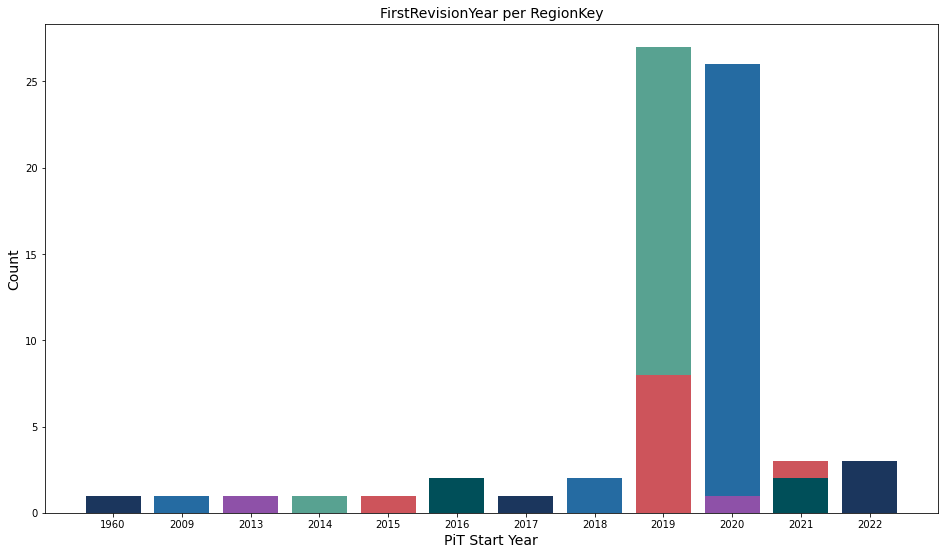

In [10]:
pyplot.rcParams["figure.figsize"] = [16,9]

Colours = [(27/255,54/255,93/255),(37/255,107/255,162/255),(142/255,81/255,168/255),(88/255,162/255,145/255),(205/255,84/255,91/255),(0/255,79/255,89/255)]
pyplot.bar(data_frame_group['FirstRevisionYear'], data_frame_group['Count'], color=Colours)
pyplot.title('FirstRevisionYear per RegionKey', fontsize=14)
pyplot.xlabel('PiT Start Year', fontsize=14)
pyplot.ylabel('Count', fontsize=14)
pyplot.grid(False)
pyplot.autoscale()
pyplot.show()